## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## 1. Compute the camera calibration using chessboard images

In [45]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

# cv2.destroyAllWindows()

# Camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None) # shape must be width * height

# # save camera matrix and distortion coefficients to pickle in folder "output_images"
# dist_pickle = {'mtx': mtx, 'dist': dist}
# pickle.dump(dist_pickle, open('./output_images/camera_mtx_dist.p', 'wb'))

## 2. Apply a distortion correction to raw images

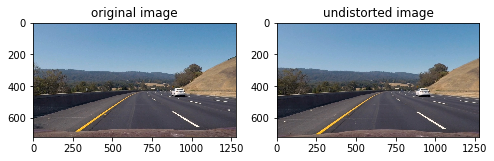

1280


In [46]:
def undistort_image(img_, mtx_, dist_,):
    """
    Undistort the image using distortion coefficients
    :param img_: Image that needs undistortion
    :param mtx_: Correction Matrix 
    :param dist_: Distortion Coefficient
    :return: Distortion Corrected Image
    """
    dst = cv2.undistort(img_, mtx_, dist_, None, mtx_)
    return dst

path='test_images/test3.jpg'
img=cv2.imread(path)
undistort=undistort_image(img, mtx, dist)
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.title('original image')
plt.imshow(img[:,:,::-1])
plt.subplot(1,2,2)
plt.title('undistorted image')
plt.imshow(undistort[:,:,::-1])
plt.show()
print(undistort.shape[1])

## 3. Use color transforms, sobel gradients to create a thresholded binary image

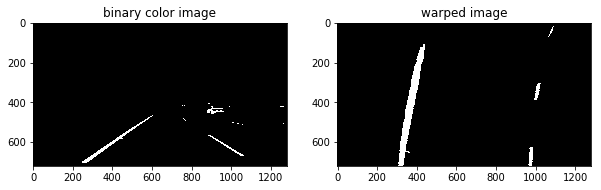

In [103]:
def abs_sobel_thresh(img, sobel_kernel=3, thresh=(0,255)):
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx=np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    scale_sobelx=np.uint8(255*sobelx/np.max(sobelx))
    sx_binary=np.zeros_like(scale_sobelx)
    sx_binary[(scale_sobelx>=thresh[0])&(scale_sobelx<=thresh[1])]=1
    return sx_binary

def hls_thresh(img, thresh_s=(0,255)):
    hls=cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel=hls[:,:,2]
    l_channel=hls[:,:,1]
    s_binary=np.zeros_like(s_channel)
    s_binary[(s_channel>=thresh_s[0])&(s_channel<=thresh_s[1])]=1
    return s_binary

def rgb_thresh(img,  Channel='r',thresh=(0,255)):  
    if Channel=='b':
        dim=0
    elif Channel=='g':
        dim=1
    else:
        dim=2
    channel=img[:,:,dim]
    binary=np.zeros_like(channel)
    binary[(channel>=thresh[0])&(channel<=thresh[1])]=1
    return binary

def hsv_thresh(img, Channel='h',thresh=(0,255)):
    hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    if Channel=='h':
        dim=0
    elif Channel=='s':
        dim=1
    else:
        dim=2
    channel=hsv[:,:,dim]
    binary=np.zeros_like(channel)
    binary[(channel>=thresh[0])&(channel<=thresh[1])]=1
    return binary

def mag_sobel_thresh(img, sobel_kernel=3, thresh=(0,255)):
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx=cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely=cv2.Sobel(gray, cv2.CV_64F ,0, 1)
    abs_sobel=np.sqrt(sobelx**2+sobely**2)
    scale_sobel=np.uint8(255*abs_sobel/np.max(abs_sobel))
    mag_binary=np.zeros_like(scale_sobel)
    mag_binary[(scale_sobel<=thresh[1]) & (scale_sobel>=thresh[0])]=1
    return mag_binary

def dir_sobel_thresh(img, sobel_kernel=3, thresh=(0,np.pi/2)):
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx=np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    sobely=np.absolute(cv2.Sobel(gray, cv2.CV_64F ,0, 1,ksize=sobel_kernel))
    dir_sobel=np.arctan2(sobely, sobelx)
    binary_output=np.zeros_like(dir_sobel)
    binary_output[(dir_sobel<=thresh[1]) & (dir_sobel>=thresh[0])]=1
    return binary_output

def Luv_thresh(img, Channel='L',thresh=(0,255)):
    Luv=cv2.cvtColor(img, cv2.COLOR_BGR2Luv)
    if Channel=='L':
        dim=0
    elif Channel=='u':
        dim=1
    else:
        dim=2
    channel=Luv[:,:,dim]
    binary=np.zeros_like(channel)
    binary[(channel<=thresh[1]) & (channel>=thresh[0])]=1
    return binary

def Lab_thresh(img, Channel='b',thresh=(0,255)):
    Lab=cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    if Channel=='L':
        dim=0
    elif Channel=='a':
        dim=1
    else:
        dim=2
    channel=Lab[:,:,dim]
    binary=np.zeros_like(channel)
    binary[(channel<=thresh[1]) & (channel>=thresh[0])]=1
    return binary
    
def combine_Luv_thresh(img,thresh_L=(0,255),thresh_u=(0,255),thresh_v=(0,255)):
    img=cv2.GaussianBlur(img, (5,5),2.0)
    L_binary=Luv_thresh(img, 'L', thresh_L)
    u_binary=Luv_thresh(img, 'u',thresh_u)
    v_binary=Luv_thresh(img, 'v',thresh_v)
    color_binary=np.zeros_like(L_binary)
    color_binary[((L_binary==1)&(u_binary==1)&(v_binary==1))]=1
    return color_binary

def combine_Lab_thresh(img, thresh_L=(0,255),thresh_a=(0,255),thresh_b=(0,255)):
    img=cv2.GaussianBlur(img,(5,5),2.0)
    L_binary=Lab_thresh(img, 'L',thresh_L)
    a_binary=Lab_thresh(img, 'a', thresh_a)
    b_binary=Lab_thresh(img, 'b', thresh_b)
    color_binary=np.zeros_like(b_binary)
    color_binary[(L_binary==1)&(a_binary==1)&(b_binary==1)]=1
    return color_binary

def combine_rgb_thresh(img, thresh_r=(0,255),thresh_g=(0,255),thresh_b=(0,255)):
    img=cv2.GaussianBlur(img, (5,5),2.0)
    r_binary=rgb_thresh(img, 'r',thresh_r)
    g_binary=rgb_thresh(img, 'g',thresh_g)
    b_binary=rgb_thresh(img, 'b', thresh_b)
    color_binary=np.zeros_like(r_binary)
    color_binary[(r_binary==1)&(g_binary==1)&(b_binary==1)]=1
    return color_binary

def edge_detection(img, thresh_L=(0,255),thresh_a=(0,255),b=(155,255),thresh_r=(177,255),thresh_g=(177,255),thresh_b=(177,255)):
    Lab_thresh=combine_Lab_thresh(img,thresh_L,thresh_a,b)
    rgb_thresh=combine_rgb_thresh(img,thresh_r,thresh_g,thresh_b)
    color_binary=np.zeros_like(Lab_thresh)
    color_binary[(Lab_thresh==1)|(rgb_thresh==1)]=1
    return color_binary

## 4. Perspeptive transform

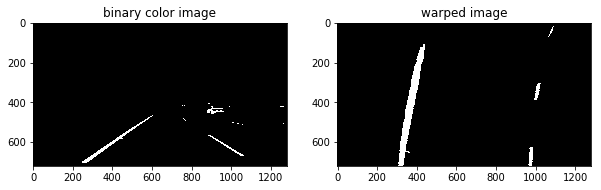

In [109]:
# Calculate Source and Destination points 
def calc_warp_points():
    """
    :return: Source and Destination pointts 
    """
    src = np.float32([[293, 668], [587, 458], [703, 458], [1028, 668]])
    dst = np.float32([[310, 720], [310, 0], [950, 0], [950, 720]])
    return src, dst



# Calculate Transform 
def calc_transform(src_, dst_):
    """
    Calculate Perspective and Inverse Perspective Transform Matrices 
    :param src_: Source points
    :param dst_: Destination Points
    :return: Perspective Matrix and Inverse Perspective Transform Matrix
    """
    M_ = cv2.getPerspectiveTransform(src_, dst_)
    Minv_ = cv2.getPerspectiveTransform(dst_, src_)
    return M_, Minv_


# Get perspective transform 
def perspective_transform(img_, M_):
    """
    :param img_ : Input Image
    :param M_: Perspective Matrix 
    :return: Transformed Image 
    """
    img_size = (img_.shape[1],img_.shape[0])
#     transformed = cv2.warpPerspective(img_, M_, img_size, flags=cv2.WARP_FILL_OUTLIERS + cv2.INTER_CUBIC)
    transformed = cv2.warpPerspective(img_, M_, img_size, flags=cv2.INTER_LINEAR)
    return transformed

binary = edge_detection(undistort)
src_, dst_ = calc_warp_points()
M, Minv = calc_transform(src_, dst_)
img_warped = perspective_transform(binary, M)
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.title('binary color image')
plt.imshow(binary, cmap='Greys_r')

plt.subplot(1,2,2)
plt.title('warped image')
plt.imshow(img_warped, cmap='Greys_r')

## 5. Find lanes lines and fit a polynomial

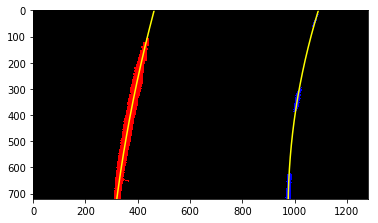

In [91]:
def blind_search(image, previous_fit, visualize=False):
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((image, image, image))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(image.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 25
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
#         # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    if(leftx.size == 0 or rightx.size == 0):
        return previous_fit[0], previous_fit[1]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    if visualize:
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    return left_fit, right_fit


def limited_search(image, previous_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video
    # It's now much easier to find line pixels!
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    
    # get last fit
    left_fit = previous_fit[0]
    right_fit = previous_fit[1]
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if(leftx.size == 0 or rightx.size == 0):
        return left_fit, right_fit
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

left_fit, right_fit = blind_search(img_warped, True,True)

## 6. Calculate curvature and car offset

In [92]:
def cal_curvature(img_width,left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # define x, y in image space
    ploty = np.linspace(0, 719, num=720)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curvature = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # calculate offset of car from lane center
    car_offset = (img_width / 2 - (left_fitx[-1] + right_fitx[-1]) / 2 ) * xm_per_pix
    
    # calculate lane width
    lane_width = (left_fitx[-1] + right_fitx[-1]) * xm_per_pix
    
    return left_curvature, right_curvature, car_offset, lane_width

## 7. Warp the detected lane boundaries back onto the original image

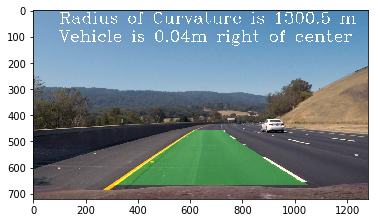

In [93]:
def draw_lane_area(undist, image, left_fit, right_fit, Minv):
    # define x,y in image space
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]  
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    img_lane = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return img_lane


def add_curvature_to_image(image, curvature, car_offset):
    # line 1 shows the curvature
    text_line1 = 'Radius of Curvature is ' + str(curvature) + ' m'
    car_offset = float('%.2f' % car_offset)
    if car_offset < 0:
        shift_direction = 'right'
    else:
        shift_direction = 'left'
    
    # line 2 shows the offset of car from lane center
    text_line2 = 'Vehicle is ' + str(abs(car_offset)) + 'm ' + shift_direction + ' of center'
    cv2.putText(image, text_line1,(100,50), cv2.FONT_HERSHEY_COMPLEX, 2,(255,255,255),2)
    cv2.putText(image, text_line2,(100,120), cv2.FONT_HERSHEY_COMPLEX, 2,(255,255,255),2)
    
def sanity_check(left_fit, right_fit):
    if len(left_fit)<3 or len(right_fit)<3:
        return False
    
    ploty=np.linspace(0, 720, 30)
    leftx=left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    rightx=right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    mean_dist=np.mean(rightx-leftx)
    dmin=np.min(rightx-leftx)
    dmax=np.max(rightx-leftx)
    
    # lane_width between 3m and 4m
    if mean_dist>=550 and mean_dist<=750:
        status=True
    else:
        return False
    
    # curvature check (car offset less than 0.42m)
    if  dmax-dmin<=80:
        status=True
    else:
        return False
    
    slope_left=2*left_fit[0]*ploty+left_fit[1] #calualuate the slope of some random selected points and compare them
    slope_right=2*right_fit[0]*ploty+right_fit[1]
    
    # left lanes and right lanes should be parallel as much as possible
    if np.mean(np.abs(slope_left-slope_right))<0.12:
        status=True
    else:
        return False
    return status

previous_fit = []
left_fit, right_fit = blind_search(img_warped, previous_fit)
left_curvature, right_curvature, car_offset, lane_width = cal_curvature(img.shape[1], left_fit, right_fit)
radius_of_curvature = int(left_curvature + right_curvature) / 2
car_offset = car_offset

# draw lane area
img_lane = draw_lane_area(img, img_warped, left_fit, right_fit, Minv)
# calculate curvature and add it on to image
add_curvature_to_image(img_lane, radius_of_curvature, car_offset)
plt.imshow(img_lane[:,:,::-1])

## Put all steps above in together and process image
Define class to keep track of all the interesting parameters you measure from frame to frame

In [104]:
class Lines():
    def __init__(self):
        # was perspective transform matrix already obtained?
        self.isPerspectiveCompute  = False
        # was the line detected in the last iteration?
        self.isLaneDetected = False  
        # is lane width reasonable?
        self.isLaneWidthSane = False
        # is curvature reasonable?
        self.IsCurvatureSane = False
        
        # x values of the last n fits of the line
        self.recent_nfits = []    
        #polynomial coefficients for the most recent fit
        self.previous_fit = [[0,0,0], [0,0,0]]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.car_offset = None 
        
        # perspective transfrom matrix
        self.M = None
        self.Minv = None
        
        
    def process_video(self, image):
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Perform Camera Calibration and  get Distortion Coefficients 
        img_undist = undistort_image(image, mtx, dist)
        
        # Calculate Bird' Eye Transform #
        if not self.isPerspectiveCompute:
            src_, dst_ = calc_warp_points()
            self.M, self.Minv = calc_transform(src_, dst_)
            self.isPerspectiveCompute = True
        
        # Get Bird's Eye View #
        img_binary = edge_detection(img_undist)
        img_warped = perspective_transform(img_binary, self.M)


        
    
        # Lane Search
        # Polynomial Search if Lane is Found
        if self.isLaneDetected:
            left_fit, right_fit = limited_search(img_warped, self.previous_fit)
        else:
            left_fit, right_fit = blind_search(img_warped, self.previous_fit)
        
        # calulate curvature, car_offset and lane width
        left_curvature, right_curvature, car_offset, lane_width = cal_curvature(image.shape[1], left_fit, right_fit)
        

        
        # sanity check
        self.isLaneDetected = sanity_check(left_fit, right_fit)
        if self.isLaneDetected:
            self.recent_nfits.append([left_fit, right_fit])
        
        # weighted average for 4 last fits
        if len(self.recent_nfits) < 4:
            self.previous_fit = np.average(np.array(self.recent_nfits), axis=0)
        else:
            self.previous_fit = np.average(np.array(self.recent_nfits[-4:]), axis=0 ,weights = np.linspace(.1, 5*.1, 4, endpoint=False))

        
        self.radius_of_curvature = int(left_curvature + right_curvature) / 2
        self.car_offset = car_offset
        
        # draw lane area
        img_lane = draw_lane_area(image, img_warped, left_fit, right_fit, self.Minv)
        # calculate curvature and add it on to image
        add_curvature_to_image(img_lane, self.radius_of_curvature, self.car_offset)
        
        return img_lane[:,:,::-1]
        

process video

In [105]:
from moviepy.editor import VideoFileClip
video_output = './output_videos/project_lane.mp4'
clip1 = VideoFileClip('./project_video.mp4')
poject_4 = Lines()
white_clip = clip1.fl_image(poject_4.process_video)
white_clip.write_videofile(video_output,audio=False)

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./output_videos/project_lane.mp4.
Moviepy - Writing video ./output_videos/project_lane.mp4



Moviepy - Done !
Moviepy - video ready ./output_videos/project_lane.mp4
